In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.listdir("/content/drive/MyDrive/data")

['train', 'test']

In [4]:
os.listdir("/content/drive/MyDrive/data/train")

['malignant', 'benign']

In [5]:
ben_dir = "/content/drive/MyDrive/data/train/benign"
malig_dir = "/content/drive/MyDrive/data/train/malignant"

train_dir = "/content/drive/MyDrive/data/train/"
test_dir = "/content/drive/MyDrive/data/test/"

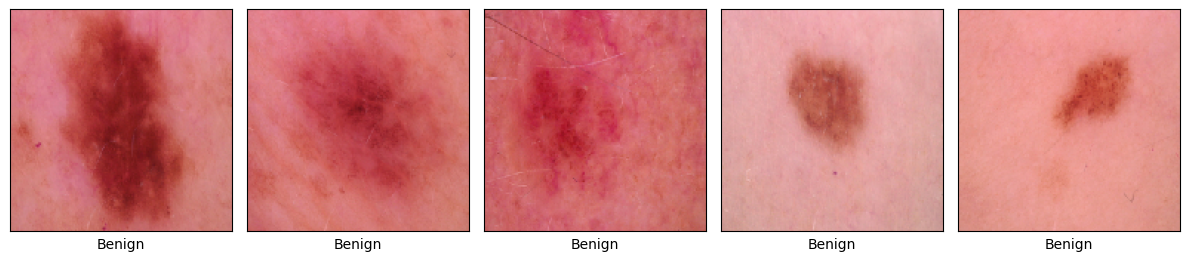

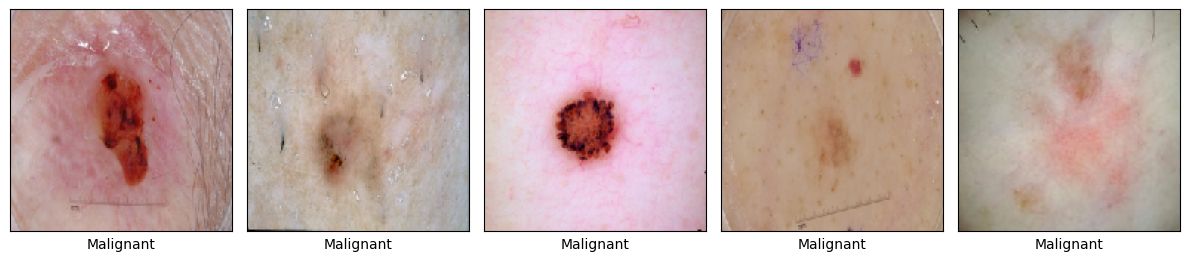

In [6]:
#Displaying random benign and malignant image samples from train directory
import random
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import load_img
plt.figure(figsize=(12,7))
ben = random.sample(os.listdir(ben_dir),5)
malig = random.sample(os.listdir(malig_dir),5)

for i,img in enumerate(ben):
    path = os.path.join(ben_dir,img)
    img = load_img(path, target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("Benign")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

plt.figure(figsize=(12,7))
for i,img in enumerate(malig):
    path = os.path.join(malig_dir,img)
    img = load_img(path, target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("Malignant")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale =(1./255),rotation_range=0.2,
    width_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest',
    horizontal_flip= True,
    validation_split=0.2)

val_datagen = ImageDataGenerator(rescale =(1./255))

train_data = train_datagen.flow_from_directory(directory = train_dir, 
                                               target_size =(224,224),
                                               class_mode = "categorical",
                                               batch_size =32,
                                               subset='training')
val_data = train_datagen.flow_from_directory(directory = train_dir, 
                                               target_size =(224,224),
                                               class_mode = "categorical",
                                               batch_size =32,
                                               subset='validation')
test_data = val_datagen.flow_from_directory(directory = test_dir, 
                                               target_size =(224,224),
                                               class_mode = "categorical",
                                               batch_size =32)

Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


>Augmented Image:

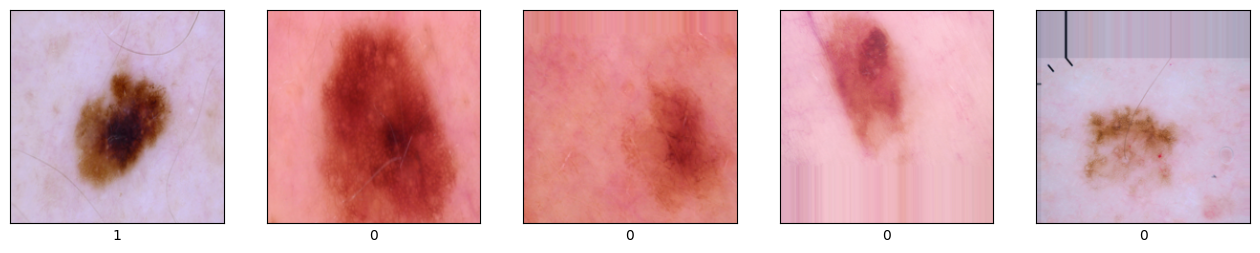

In [8]:
from tensorflow.keras.preprocessing import image
sample_x, sample_y = next(train_data)
plt.figure(figsize=(16,9))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = image.img_to_array(sample_x[i])
    plt.imshow(img)
    plt.xlabel(np.argmax(sample_y[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [9]:
from tensorflow.keras.applications import DenseNet121
dense = DenseNet121(weights = "imagenet", include_top = False, input_shape=(224,224,3))

29084464/29084464 [==============================] - 0s 0us/step


In [10]:
for layer in dense.layers[:121]:
    layer.trainable = False

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D, 
Flatten, Dropout, BatchNormalization

model = Sequential()
model.add(dense)
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512,activation= "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 1024)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 3, 3, 1024)       4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 3, 3, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 512)               4

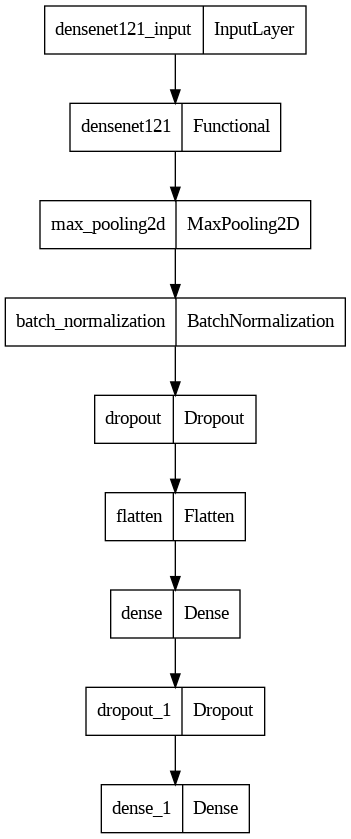

In [13]:
plot_model(model,
    to_file='DenseNet.png',
    show_shapes=False,
    show_layer_names=True)

In [14]:
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
metrics = ['accuracy']

lr=0.001
model.compile(optimizer = Adam(learning_rate = 0.001), loss = "categorical_crossentropy", metrics = metrics)

In [15]:
patience = 1
stop_patience = 3
factor = 0.5
#    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("densenet121.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
]

In [16]:
history = model.fit(train_data, validation_data = val_data, epochs = 20, 
                    verbose = 1, callbacks = callbacks )

Epoch 1/20
66/66 [==============================] - 301s 4s/step - loss: 0.6538 - accuracy: 0.7981 - val_loss: 15.2549 - val_accuracy: 0.5503 - lr: 0.0010
Epoch 2/20
66/66 [==============================] - 45s 675ms/step - loss: 0.3404 - accuracy: 0.8455 - val_loss: 2.4030 - val_accuracy: 0.6793 - lr: 0.0010
Epoch 3/20
66/66 [==============================] - 47s 716ms/step - loss: 0.2845 - accuracy: 0.8621 - val_loss: 0.5679 - val_accuracy: 0.8216 - lr: 0.0010
Epoch 4/20
66/66 [==============================] - 46s 694ms/step - loss: 0.2506 - accuracy: 0.8839 - val_loss: 0.3787 - val_accuracy: 0.8501 - lr: 0.0010
Epoch 5/20
66/66 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.8919
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
66/66 [==============================] - 45s 687ms/step - loss: 0.2374 - accuracy: 0.8919 - val_loss: 0.5917 - val_accuracy: 0.7552 - lr: 0.0010
Epoch 6/20
66/66 [==============================] - ETA: 0s - 

In [17]:
model.save("densenet121.h5")
model.evaluate(test_data)

21/21 [==============================] - 105s 5s/step - loss: 0.2848 - accuracy: 0.9045


[0.28478896617889404, 0.9045454263687134]

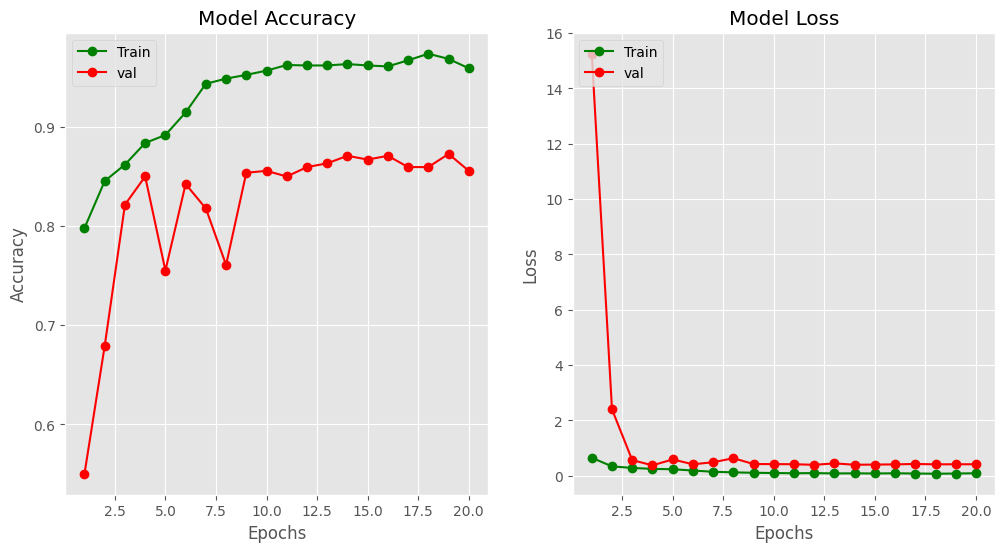

In [19]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,21)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")
#plt.show()

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

In [21]:
# import necessary layers  
from tensorflow.keras.layers import Input, Conv2D 
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras import Model
# input
input = Input(shape =(224,224,3))
# 1st Conv Block
x = Conv2D (filters =8, kernel_size =3, padding ='valid', activation='relu')(input)
x = Conv2D (filters =8, kernel_size =3, padding ='valid', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# 2nd Conv Block
x = Conv2D (filters =16, kernel_size =3, padding ='valid', activation='relu')(x)
x = Conv2D (filters =16, kernel_size =3, padding ='valid', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# 3rd Conv block
x = Conv2D (filters =32, kernel_size =3, padding ='valid', activation='relu')(x)
x = Conv2D (filters =32, kernel_size =3, padding ='valid', activation='relu')(x)
#x = Conv2D (filters =32, kernel_size =3, padding ='valid', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# 4th Conv block
x = Conv2D (filters =64, kernel_size =3, padding ='valid', activation='relu')(x)
x = Conv2D (filters =64, kernel_size =3, padding ='valid', activation='relu')(x)
#x = Conv2D (filters =64, kernel_size =3, padding ='valid', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# 5th Conv block
x = Conv2D (filters =64, kernel_size =3, padding ='valid', activation='relu')(x)
x = Conv2D (filters =64, kernel_size =3, padding ='valid', activation='relu')(x)
#x = Conv2D (filters =64, kernel_size =3, padding ='valid', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# Fully connected layers
x = Flatten()(x)
#x = Dense(units = 1028, activation ='relu')(x)
x = Dense(units = 256, activation ='relu')(x)
x = Dropout(0.5)(x)
output = Dense(units = 2)(x)   #last layer with linear activation
# creating the model
s_model_1 = Model (inputs=input, outputs =output)
s_model_1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 8)       584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 110, 110, 8)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 16)      1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 16)      2320      
                                                             

In [22]:
import keras

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student
    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.5,
        temperature=2,
    ):
        """ Configure the distiller.
        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
    def train_step(self, data):
        # Unpack data
        x, y = data
        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        #model = ...  # create the original model
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            # Forward pass of student
            # Forward pass of student
            student_predictions = self.student(x, training=True)
            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss +  distillation_loss
        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results
    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_prediction = self.student(x, training=False)
        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


In [23]:
from tensorflow.keras.losses import CategoricalCrossentropy

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("densenet121.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_student_loss', factor=factor, patience=patience, verbose=1)
]
# Initialize and compile distiller
distiller = Distiller(student=s_model_1, teacher=model)
distiller.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=['acc'],
    student_loss_fn=CategoricalCrossentropy(from_logits=True),
distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.5,
    temperature=6,
)
# Distill teacher to student
distiller_hist = distiller.fit(train_data, validation_data = val_data, epochs=20,callbacks = callbacks)


Epoch 1/20
66/66 [==============================] - ETA: 0s - acc: 0.5450 - student_loss: 0.6885 - distillation_loss: 0.0031

66/66 [==============================] - 55s 652ms/step - acc: 0.5450 - student_loss: 0.6885 - distillation_loss: 0.0031 - val_acc: 0.5465 - val_student_loss: 0.6745 - lr: 1.0000e-04
Epoch 2/20
66/66 [==============================] - ETA: 0s - acc: 0.5483 - student_loss: 0.6814 - distillation_loss: 0.0031


Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
66/66 [==============================] - 40s 608ms/step - acc: 0.5483 - student_loss: 0.6819 - distillation_loss: 0.0031 - val_acc: 0.5465 - val_student_loss: 0.6966 - lr: 1.0000e-04
Epoch 3/20
66/66 [==============================] - ETA: 0s - acc: 0.5905 - student_loss: 0.6640 - distillation_loss: 0.0028

66/66 [==============================] - 39s 597ms/step - acc: 0.5905 - student_loss: 0.6635 - distillation_loss: 0.0028 - val_acc: 0.6300 - val_student_loss: 0.5925 - lr: 5.0000e-05
Epoch 4/20
66/66 [==============================] - ETA: 0s - acc: 0.7052 - student_loss: 0.5802 - distillation_loss: 0.0028

66/66 [==============================] - 40s 601ms/step - acc: 0.7052 - student_loss: 0.5790 - distillation_loss: 0.0028 - val_acc: 0.6471 - val_student_loss: 0.4662 - lr: 5.0000e-05
Epoch 5/20
66/66 [==============================] - ETA: 0s - acc: 0.7398 - student_loss: 0.5297 - distillation_loss: 0.0042

66/66 [==============================] - 40s 603ms/step - acc: 0.7398 - student_loss: 0.5283 - distillation_loss: 0.0042 - val_acc: 0.7306 - val_student_loss: 0.4587 - lr: 5.0000e-05
Epoch 6/20
66/66 [==============================] - ETA: 0s - acc: 0.7720 - student_loss: 0.4795 - distillation_loss: 0.0042


Epoch 6: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
66/66 [==============================] - 40s 607ms/step - acc: 0.7720 - student_loss: 0.4789 - distillation_loss: 0.0042 - val_acc: 0.7514 - val_student_loss: 0.7359 - lr: 5.0000e-05
Epoch 7/20
66/66 [==============================] - ETA: 0s - acc: 0.7934 - student_loss: 0.4439 - distillation_loss: 0.0051


Epoch 7: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
66/66 [==============================] - 40s 604ms/step - acc: 0.7934 - student_loss: 0.4445 - distillation_loss: 0.0051 - val_acc: 0.7230 - val_student_loss: 0.4914 - lr: 2.5000e-05
Epoch 8/20
66/66 [==============================] - ETA: 0s - acc: 0.7900 - student_loss: 0.4475 - distillation_loss: 0.0056


Epoch 8: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
66/66 [==============================] - 42s 635ms/step - acc: 0.7900 - student_loss: 0.4492 - distillation_loss: 0.0056 - val_acc: 0.7059 - val_student_loss: 0.5783 - lr: 1.2500e-05
Epoch 9/20
66/66 [==============================] - ETA: 0s - acc: 0.7891 - student_loss: 0.4390 - distillation_loss: 0.0056


Epoch 9: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
66/66 [==============================] - 42s 635ms/step - acc: 0.7891 - student_loss: 0.4388 - distillation_loss: 0.0056 - val_acc: 0.7154 - val_student_loss: 0.5805 - lr: 6.2500e-06
Epoch 10/20
66/66 [==============================] - ETA: 0s - acc: 0.7915 - student_loss: 0.4365 - distillation_loss: 0.0056

66/66 [==============================] - 40s 604ms/step - acc: 0.7915 - student_loss: 0.4355 - distillation_loss: 0.0056 - val_acc: 0.7135 - val_student_loss: 0.4110 - lr: 3.1250e-06
Epoch 11/20
66/66 [==============================] - ETA: 0s - acc: 0.7934 - student_loss: 0.4358 - distillation_loss: 0.0057


Epoch 11: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
66/66 [==============================] - 39s 596ms/step - acc: 0.7934 - student_loss: 0.4381 - distillation_loss: 0.0057 - val_acc: 0.7116 - val_student_loss: 0.5493 - lr: 3.1250e-06
Epoch 12/20
66/66 [==============================] - ETA: 0s - acc: 0.7934 - student_loss: 0.4321 - distillation_loss: 0.0057


Epoch 12: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
66/66 [==============================] - 42s 632ms/step - acc: 0.7934 - student_loss: 0.4327 - distillation_loss: 0.0057 - val_acc: 0.7173 - val_student_loss: 0.7469 - lr: 1.5625e-06
Epoch 13/20
66/66 [==============================] - ETA: 0s - acc: 0.7962 - student_loss: 0.4307 - distillation_loss: 0.0057


Epoch 13: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
66/66 [==============================] - 39s 595ms/step - acc: 0.7962 - student_loss: 0.4310 - distillation_loss: 0.0057 - val_acc: 0.7249 - val_student_loss: 0.5532 - lr: 7.8125e-07
Epoch 14/20
66/66 [==============================] - ETA: 0s - acc: 0.8014 - student_loss: 0.4291 - distillation_loss: 0.0059


Epoch 14: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.
66/66 [==============================] - 42s 636ms/step - acc: 0.8014 - student_loss: 0.4313 - distillation_loss: 0.0059 - val_acc: 0.7287 - val_student_loss: 0.6437 - lr: 3.9062e-07
Epoch 15/20
66/66 [==============================] - ETA: 0s - acc: 0.7953 - student_loss: 0.4318 - distillation_loss: 0.0058


Epoch 15: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.
66/66 [==============================] - 39s 598ms/step - acc: 0.7953 - student_loss: 0.4317 - distillation_loss: 0.0058 - val_acc: 0.7249 - val_student_loss: 0.6741 - lr: 1.9531e-07
Epoch 16/20
66/66 [==============================] - ETA: 0s - acc: 0.8024 - student_loss: 0.4280 - distillation_loss: 0.0059


Epoch 16: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
66/66 [==============================] - 42s 634ms/step - acc: 0.8024 - student_loss: 0.4268 - distillation_loss: 0.0059 - val_acc: 0.7362 - val_student_loss: 0.4387 - lr: 9.7656e-08
Epoch 17/20
66/66 [==============================] - ETA: 0s - acc: 0.7905 - student_loss: 0.4337 - distillation_loss: 0.0058


Epoch 17: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
66/66 [==============================] - 39s 597ms/step - acc: 0.7905 - student_loss: 0.4329 - distillation_loss: 0.0058 - val_acc: 0.7324 - val_student_loss: 0.5579 - lr: 4.8828e-08
Epoch 18/20
66/66 [==============================] - ETA: 0s - acc: 0.7995 - student_loss: 0.4348 - distillation_loss: 0.0058


Epoch 18: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
66/66 [==============================] - 39s 590ms/step - acc: 0.7995 - student_loss: 0.4342 - distillation_loss: 0.0058 - val_acc: 0.7400 - val_student_loss: 0.8340 - lr: 2.4414e-08
Epoch 19/20
66/66 [==============================] - ETA: 0s - acc: 0.7953 - student_loss: 0.4298 - distillation_loss: 0.0059


Epoch 19: ReduceLROnPlateau reducing learning rate to 6.103515470812226e-09.
66/66 [==============================] - 39s 584ms/step - acc: 0.7953 - student_loss: 0.4295 - distillation_loss: 0.0059 - val_acc: 0.7211 - val_student_loss: 0.6413 - lr: 1.2207e-08
Epoch 20/20
66/66 [==============================] - ETA: 0s - acc: 0.7962 - student_loss: 0.4330 - distillation_loss: 0.0057


Epoch 20: ReduceLROnPlateau reducing learning rate to 3.051757735406113e-09.
66/66 [==============================] - 39s 592ms/step - acc: 0.7962 - student_loss: 0.4350 - distillation_loss: 0.0057 - val_acc: 0.7287 - val_student_loss: 0.4466 - lr: 6.1035e-09


In [24]:
print(distiller.metrics_names)
acc, loss = distiller.evaluate(test_data, verbose = 1) 
print('test loss = ', loss)
print('test accuracy = ',acc)


['acc']
21/21 [==============================] - 3s 152ms/step - acc: 0.7788 - student_loss: 0.4799
test loss =  0.7409484386444092
test accuracy =  0.7787878513336182


Test set shape :  (660, 224, 224, 3)
21/21 [==============================] - 4s 94ms/step


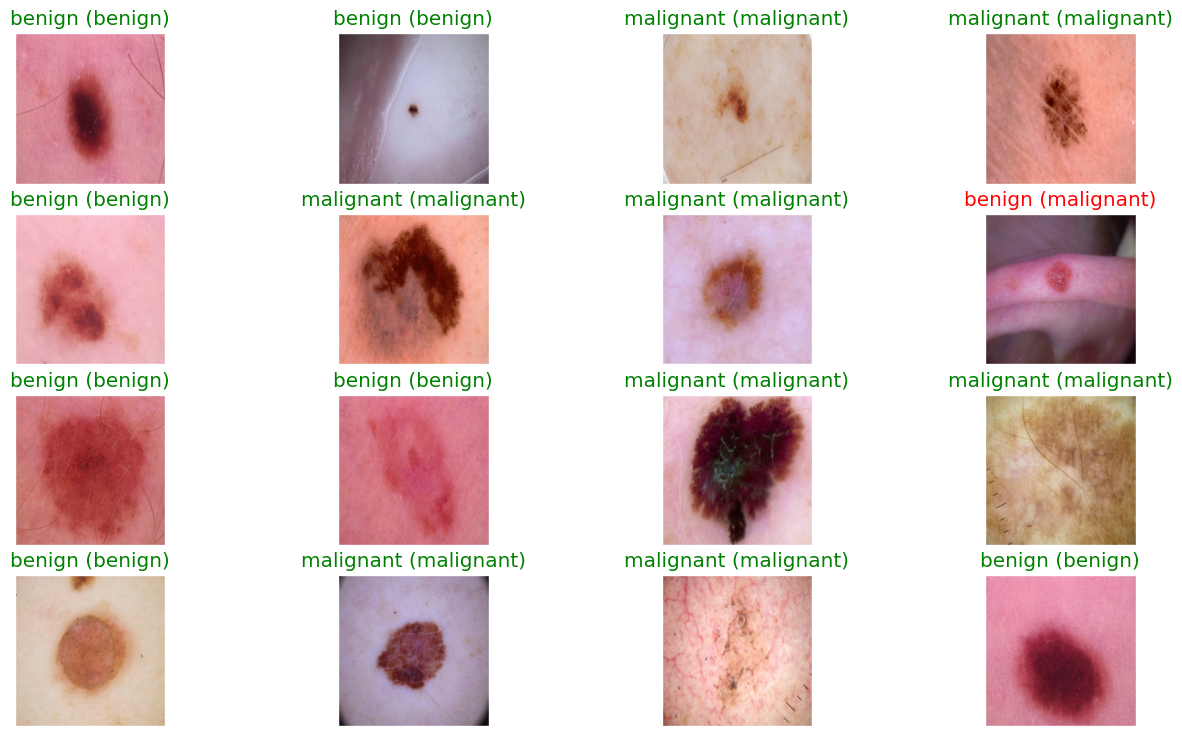

In [26]:
import numpy as np
from sklearn.datasets import load_files
from keras.utils import array_to_img, img_to_array, load_img
from keras.utils import np_utils
import tensorflow as tf
test_dir = "/content/drive/MyDrive/data/test/"
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

x_test, y_test,target_labels = load_dataset(test_dir)
no_of_classes=2
y_test = np_utils.to_categorical(y_test,no_of_classes)
# We just have the file names in the x set. Let's load the images and convert them into array.
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(tf.image.resize(img_to_array(load_img(file)), (224, 224)))
    return images_as_array
x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)
x_test = x_test.astype('float32')/255
# Let's visualize test prediction.
y_pred = model.predict(x_test)
# y_pred = tf.nn.softmax(y_pred_logits)
# plot a raandom sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
